In [1]:
import pandas
from sklearn.linear_model import MultiTaskElasticNetCV, ElasticNetCV
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.ensemble import BaggingRegressor
from scipy.stats import pearsonr
%matplotlib inline
import matplotlib.pyplot as plt 


Bad key "axes.spines.right" on line 210 in
/Users/alex/Applications/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "boxplot.flierprops.linewidth" on line 321 in
/Users/alex/Applications/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "contour.corner_mask" on line 306 in
/Users/alex/Applications/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "boxplot.vertical" on line 339 in
/Users/alex/Applications/anaconda/lib/pyt

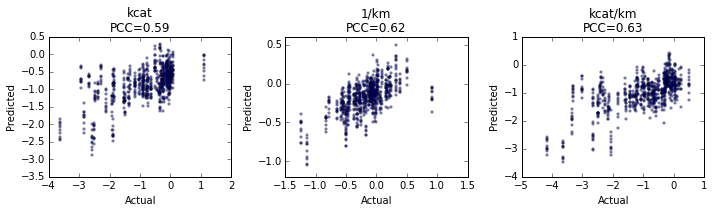

In [7]:
# this is the new benchmark script 

def low_10( df ):
    return df.sort( 'total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/original.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

drop_list = [ u'all_cst', u'tot_seq_recovery', u'SR_1', u'SR_1_all_cst', u'SR_2', u'SR_2_all_cst', u'SR_3', u'SR_3_all_cst', u'SR_4', u'SR_4_all_cst', u'SR_5', u'SR_5_all_cst' ]
df.drop( drop_list, inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )

constants = [ 'kcat', '1/km', 'kcat/km' ]

for const_index, constant in enumerate( constants ): 
    
    X = df.join( train_set ).dropna()
    y = X[ constant ].values
    X = X.ix[ :,:'expressed' ].values

    net = ElasticNetCV( normalize=True, selection='random' )

    params_grid = {
        'cv': [ 10 ], 
        'l1_ratio': [ 0.001, 0.01, 0.1, 0.5, 0.9 ], 
    }

    grid = GridSearchCV( net, params_grid )
    bag = BaggingRegressor( base_estimator = grid )
    bag.fit( X, y )

    preds = [ bag.predict( X[i] ) for i in range( len( X ) ) ]
    actuals = [ y[i] for i in range( len( X ) ) ]

    xvalues = [ preds[n][0] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n] for n in range( len( actuals ) ) ]

    ax[ const_index ].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    ax[ const_index ].set_xlabel( 'Actual' )
    ax[ const_index ].set_ylabel( 'Predicted' )
    ax[ const_index ].set_title( '{}\nPCC={:.2}'.format( constant, pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

In [ ]:
# all things below here are suspect! 






























In [ ]:
df = pandas.read_csv( 'benchmarks/detect.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df.set_index( 'description', inplace=True )
train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
X = df.join( train_set ).dropna()

y = X.ix[:,'kcat':]
X = X.ix[:,:'expressed'] 

net = MultiTaskElasticNetCV( selection='random', normalize=True )

params_grid = {
    'cv': [ 3, 4, 5, 10, 25, 50 ], 
    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
}

grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print grid.score( X, y )
print grid.best_params_

preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

In [ ]:
def low_10( df ):
    return df.sort_values( by='total_score' ).head( 1 )

df = pandas.read_csv( 'benchmarks/whole10.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
X = df.join( train_set ).dropna()

y = X.ix[:,'kcat':]
X = X.ix[:,:'expressed'] 

net = MultiTaskElasticNetCV( selection='random', normalize=True )

params_grid = {
    'cv': [ 3, 6, 10 ], 
    'l1_ratio': [ 0.0001, 0.001, 0.01, 0.1, 0.5, 0.99 ], 
}

grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print grid.score( X, y )
print grid.best_params_

preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.', color='red' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

In [ ]:
from sklearn.linear_model import ElasticNetCV

def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/whole.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
#df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
X = df.join( train_set ).dropna()

yy = [ X.kcat, X['1/km'], X['kcat/km'] ]
X = X.ix[:,:'expressed'] 

fig, ax = plt.subplots()

for y in yy:
    net = ElasticNetCV()

    params_grid = {
        'cv': [ 3, 6, 10 ], 
        'l1_ratio': [ 0.0001, 0.001, 0.01, 0.1, 0.5 ], 
    }

    grid = GridSearchCV( net, params_grid )
    grid.fit( X, y )

    print grid.score( X, y )
    print grid.best_params_

    preds = [ grid.predict( X.iloc[i].reshape( 1, -1 )[0] ) for i in range( len( X ) ) ]

    actuals = [ y.iloc[i] for i in range( len( X ) ) ]
    #print preds, actuals
    plt.scatter( preds, actuals, alpha=0.4, marker='.', color='red' )
    plt.xlabel( 'Actual' )
    plt.ylabel( 'Predicted' )
    #plt.title( '{}\nPCC={:.2}'.format( 'whatever', pearsonr( preds, actuals ) ) )
    plt.show()

In [ ]:
#original as in PLOS paper 
def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/original.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

drop_list = [ u'all_cst', u'tot_seq_recovery', u'SR_1', u'SR_1_all_cst', u'SR_2', u'SR_2_all_cst', u'SR_3', u'SR_3_all_cst', u'SR_4', u'SR_4_all_cst', u'SR_5', u'SR_5_all_cst' ]
df.drop( drop_list, inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

X = df.join( train_set ).dropna()
y = X.kcat
X = X.ix[:,:'expressed'] 

net = MultiElasticNetCV()

params_grid = {
    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
}

from sklearn.ensemble import BaggingRegressor
grid = GridSearchCV( net, params_grid )
bag = BaggingRegressor( base_estimator = grid )

bag.fit( X, y )

In [ ]:
print 'Model score:', bag.score( X, y )

In [ ]:
preds = [ bag.predict( X.iloc[i].reshape(1,-1) )[0] for i in range( len( X ) ) ] 

In [ ]:
plt.scatter( preds, y, alpha=0.5 )
print pearsonr( preds, y )

In [ ]:
!rsync -avz $ep:bagel-learn/benchmark/features_reporter/features.db3 .

In [ ]:
!ls

In [ ]:
import sqlite3
from sklearn.cross_validation import cross_val_predict
from sklearn.ensemble import BaggingRegressor

con = sqlite3.connect( 'features.db3' )
for i in [ 'interfaces', 'interface_sides' ]:
    f = pandas.read_sql_query( 'select * from {}'.format( i ), con, index_col='struct_id' )

names = pandas.read_sql_query( 'select * from structures', con, index_col='struct_id' )
feats = f.join( names ).dropna()
#print f.head()
#print names.head()
#print feats.head()

feats['shlag'] = feats.tag.str[:-10]
feats.set_index( 'shlag', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

J = feats.join( train_set ).dropna()

y = J.ix[:,'kcat':]
X = J.ix[:,'dSASA':'batch_id'] 

net = MultiTaskElasticNetCV( )
params_grid = { 'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 'cv': [ 10 ] }
grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print 'Model score:', grid.score( X, y )
print 'Found params:', grid.best_params_
preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

#bag = BaggingRegressor( base_estimator = grid )
#bag.fit( X, y )

#net = ElasticNetCV(cv=strat)

#preds = cross_val_predict( bag, X, y=y, cv=strat )
#net.fit( X, y )
#constants = ['kcat', '1/km', 'kcat/km']
#preds = pandas.DataFrame( preds, columns=constants )
#actuals = pandas.DataFrame( y, columns=constants )
#for c in constants:
#    plt.scatter( preds[c], actuals[c] )
#    plt.show()

In [ ]:
def low_10( df ):
    return df.sort_values( by='total_score' ).head( 10 )

df = pandas.read_csv( 'benchmarks/whole.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df = df.groupby( 'description' ).apply( low_10 )
df.set_index( 'description', inplace=True )

train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
X = df.join( train_set ).dropna()

y = X.ix[:,'kcat':]
X = X.ix[:,:'expressed'] 

net = MultiTaskElasticNetCV( selection='random', normalize=True )

params_grid = {
    'cv': [ 3, 6, 10 ], 
    'l1_ratio': [ 0.0001, 0.001, 0.01, 0.1, 0.5 ], 
}

grid = GridSearchCV( net, params_grid )
grid.fit( X, y )

print grid.score( X, y )
print grid.best_params_

preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
actuals = [ y.iloc[i] for i in range( len( X ) ) ]

fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
for i in range( 3 ):
    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.', color='red' )
    ax[i].set_xlabel( 'Actual' )
    ax[i].set_ylabel( 'Predicted' )
    ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
    plt.tight_layout()

In [ ]:

#X = df.join( train_set ).dropna()

#y = X.ix[:,'kcat':]
#X = X.ix[:,:'expressed'] 

#net = MultiTaskElasticNetCV( selection='random', normalize=True )

#params_grid = {
#    'cv': [ 3, 4, 5, 10, 25, 50 ], 
#    'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
#}

#grid = GridSearchCV( net, params_grid )
#grid.fit( X, y )

#print grid.score( X, y )
#print grid.best_params_

#preds = [ grid.predict( X.iloc[i].reshape( 1, -1 ) ) for i in range( len( X ) ) ]
#actuals = [ y.iloc[i] for i in range( len( X ) ) ]
#print 'Pearson {}'.format( pearsonr( preds, actuals ) )

#fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(10,3) )
#for i in range( 3 ):
#    xvalues = [ preds[n][0][i] for n in range( len( preds ) ) ]
#    yvalues = [ actuals[n][i] for n in range( len( actuals ) ) ]
#    ax[i].scatter( yvalues, xvalues, alpha=0.4, marker='.' )
#    ax[i].set_xlabel( 'Actual' )
#    ax[i].set_ylabel( 'Predicted' )
#   ax[i].set_title( '{}\nPCC={:.2}'.format( y.columns[i], pearsonr( xvalues, yvalues )[0] ) )
#    plt.tight_layout()

In [ ]:
from sklearn.preprocessing import normalize

df = pandas.read_csv( 'benchmarks/detect.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df.set_index( 'description', inplace=True )
train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )

constants = [ 'kcat', '1/km', 'kcat/km' ]
from sklearn.cross_validation import StratifiedKFold
for constant in constants:
    X = df.join( train_set ).dropna()
    y = X[constant].values
    X = normalize( X.ix[:,:'expressed'].values )
    strat = StratifiedKFold( y, n_folds=10 )
    net = ElasticNetCV( selection='random', normalize=True, cv=strat )

    params_grid = {
        'l1_ratio': [ 0.001, 0.01, 0.1, 0.5 ], 
    }

    grid = GridSearchCV( net, params_grid )
    grid.fit( X, y )

    print grid.score( X, y )
    print grid.best_params_

    preds = [ grid.predict( X[i].reshape( 1, -1 ) )[0] for i in range( len( X ) ) ]
    actuals = [ y.iloc[i] for i in range( len( X ) ) ]
    pcc = pearsonr( preds, actuals ) 

    xvalues = [ preds[n] for n in range( len( preds ) ) ]
    yvalues = [ actuals[n] for n in range( len( actuals ) ) ]
    plt.scatter( yvalues, xvalues, alpha=0.4, marker='.' )
    plt.xlabel( 'Actual' )
    plt.ylabel( 'Predicted' )
    plt.title( '{}\nPCC={:.2}'.format( constant, pcc[0] ) )
    plt.show()

In [ ]:
from sklearn.linear_model import MultiTaskElasticNetCV, ElasticNetCV
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import normalize
from scipy.stats import pearsonr
import pandas
%matplotlib inline
import matplotlib.pyplot as plt 

df = pandas.read_csv( 'benchmarks/detect.sc', sep=r'\s+' ).dropna()
df.description = df.description.str[:-5]
df.set_index( 'description', inplace=True )
train_set = pandas.read_csv( '../data/train_set.csv' )
train_set.set_index( 'mutant', inplace=True )
j = df.join( train_set ).dropna()
corr = j.corr()

constants = ['kcat', '1/km', 'kcat/km']
for const in constants:    
    top_4 = corr[const][ corr[const].abs() > 0.25 ] #get( 'kcat' )
    print top_4
    
